In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import sqlite3 as db

match_attr_query = 'select \
M.id as match_id \
,L.name as league_name \
,C.name as country_name \
,HT.team_long_name as home_team_long_name \
,HT.team_short_name as home_team_short_name \
,M.home_team_api_id as home_team_api_id \
,M.away_team_api_id as away_team_api_id \
,AT.team_long_name as away_team_long_name \
,AT.team_short_name as away_team_short_name \
,M.home_team_goal as home_team_goals \
,M.away_team_goal as away_team_goals \
,M.shoton \
,M.shotoff \
,M.corner \
,M.foulcommit \
,M.card \
,M.cross \
,M.possession \
from [Match] as M \
join League as L on M.league_id = L.id \
join Country as C on C.id = L.country_id \
join Team as HT on HT.team_api_id = M.home_team_api_id \
join Team as AT on AT.team_api_id = M.away_team_api_id'

conn = db.connect("database.sqlite")
df = pd.read_sql_query(match_attr_query, conn)
df.head(5)




,match_id,league_name,country_name,home_team_long_name,home_team_short_name,home_team_api_id,away_team_api_id,away_team_long_name,away_team_short_name,home_team_goals,away_team_goals,shoton,shotoff,corner,foulcommit,card,cross,possession
0,1,Belgium Jupiler League,Belgium,KRC Genk,GEN,9987,9993,Beerschot AC,BAC,1,1,None,None,None,None,None,None,None
1,2,Belgium Jupiler League,Belgium,SV Zulte-Waregem,ZUL,10000,9994,Sporting Lokeren,LOK,0,0,None,None,None,None,None,None,None
2,3,Belgium Jupiler League,Belgium,KSV Cercle Brugge,CEB,9984,8635,RSC Anderlecht,AND,0,3,None,None,None,None,None,None,None
3,4,Belgium Jupiler League,Belgium,KAA Gent,GEN,9991,9998,RAEC Mons,MON,5,0,None,None,None,None,None,None,None
4,5,Belgium Jupiler League,Belgium,FCV Dender EH,DEN,7947,9985,Standard de Liège,STL,1,3,None,None,None,None,None,None,None


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 18 columns):
match_id                25979 non-null int64
league_name             25979 non-null object
country_name            25979 non-null object
home_team_long_name     25979 non-null object
home_team_short_name    25979 non-null object
home_team_api_id        25979 non-null int64
away_team_api_id        25979 non-null int64
away_team_long_name     25979 non-null object
away_team_short_name    25979 non-null object
home_team_goals         25979 non-null int64
away_team_goals         25979 non-null int64
shoton                  14217 non-null object
shotoff                 14217 non-null object
corner                  14217 non-null object
foulcommit              14217 non-null object
card                    14217 non-null object
cross                   14217 non-null object
possession              14217 non-null object
dtypes: int64(5), object(13)
memory usage: 3.6+ MB


In [3]:
df.dropna(inplace=True)

In [4]:
sum(df.duplicated())

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14217 entries, 1728 to 25948
Data columns (total 18 columns):
match_id                14217 non-null int64
league_name             14217 non-null object
country_name            14217 non-null object
home_team_long_name     14217 non-null object
home_team_short_name    14217 non-null object
home_team_api_id        14217 non-null int64
away_team_api_id        14217 non-null int64
away_team_long_name     14217 non-null object
away_team_short_name    14217 non-null object
home_team_goals         14217 non-null int64
away_team_goals         14217 non-null int64
shoton                  14217 non-null object
shotoff                 14217 non-null object
corner                  14217 non-null object
foulcommit              14217 non-null object
card                    14217 non-null object
cross                   14217 non-null object
possession              14217 non-null object
dtypes: int64(5), object(13)
memory usage: 2.1+ MB


In [6]:
class XML2DataFrame:

    def __init__(self, xml_data):
        self.root = ET.XML(xml_data)

    def parse_root(self, root):
        return [self.parse_element(child) for child in iter(root)]

    def parse_element(self, element, parsed=None):
        if parsed is None:
            parsed = dict()
        for key in element.keys():
            parsed[key] = element.attrib.get(key)
        if element.text:
            parsed[element.tag] = element.text
        for child in list(element):
            self.parse_element(child, parsed)
        return parsed

    def process_data(self):
        structure_data = self.parse_root(self.root)
        return pd.DataFrame(structure_data)


In [7]:
def parse_xml_data(dataFrame, colName=None):    
    
        xml2df = XML2DataFrame(dataFrame[colName])
        xml_dataframe = xml2df.process_data()
        
        home_team_api_id = dataFrame['home_team_api_id']
        away_team_api_id = dataFrame['away_team_api_id']                    
        
        if colName in ['corner', 'shoton', 'shotoff', 'foulcommit']:
            series = pd.Series([None, None])
            try:                
                if 'team' in xml_dataframe.columns:
                    data_values = xml_dataframe.groupby('team').count()['id'].reset_index()
                    data_values['team'] = data_values['team'].astype(int) 
                    
                    home_team_data_value = data_values[data_values['team'] == home_team_api_id]['id']
                    away_team_data_value = data_values[data_values['team'] == away_team_api_id]['id']
                    series =  pd.Series([  0 if home_team_data_value.count() == 0 else home_team_data_value.iloc[0],      
                                         0 if away_team_data_value.count() == 0 else away_team_data_value.iloc[0]])                
            except:
                print('{0} : {1} Problematic Index'.format( colName, dataFrame['match_id']))
            return series
        elif colName == 'possession':
            series = pd.Series([None, None])
            try:
                if set(xml_dataframe.columns).issuperset(set(['awaypos','homepos', 'elapsed'])) :  
                    ### There could be data where elapsed time is not 90.. 
                    ### We need to highest elapsed and parse the data.
                    
                    xml_dataframe['elapsed']  = xml_dataframe['elapsed'].astype(int)
                    row_with_max_elapsed = xml_dataframe['elapsed'].idxmax()
                    
                    homepossesion_time = xml_dataframe.iloc[row_with_max_elapsed]['homepos'] 
                    awaypossesion_time = xml_dataframe.iloc[row_with_max_elapsed]['awaypos']
                   
                    #print(homepossesion_time)
                        
                    series = pd.Series([homepossesion_time, awaypossesion_time])   
                    
            except Exception as e:
                    print(e)
                    print('{0} : {1} Problematic Index'.format( colName, dataFrame['match_id']))
            return series
        elif colName == 'card':            
            series = pd.Series([None, None, None, None])
            #print(xml_dataframe)
            try:                
                if set(xml_dataframe.columns).issuperset(set(['team', 'ycards'])):                    
                    yCard_frame = xml_dataframe.groupby(['team','ycards']).count()['id'].reset_index()
                    #print(yCard_frame)
                    #print('ddd')
                    #print(home_team_api_id)
                    
                    yCard_frame['team'] = yCard_frame['team'].astype(int) 
                    #print(yCard_frame[(yCard_frame['team'] == home_team_api_id) & (yCard_frame['ycards'] == '1')])
                    home_team_data_value = yCard_frame[(yCard_frame['team'] == home_team_api_id) & (yCard_frame['ycards'] == '1')]['id']
                    away_team_data_value = yCard_frame[(yCard_frame['team'] == away_team_api_id) & (yCard_frame['ycards'] == '1')]['id']                   
                    #print(home_team_data_value)
                    series[0] = 0 if home_team_data_value.count() == 0 else home_team_data_value.iloc[0]
                    series[1] = 0 if away_team_data_value.count() == 0 else away_team_data_value.iloc[0]
                    
                    #update red card 0 for now, rather than None.
                    series[2] = 0
                    series[3] = 0
                 
                if set(xml_dataframe.columns).issuperset(set(['team', 'rcards'])):
                    
                    rCard_frame = xml_dataframe.groupby(['team','rcards']).count()['id'].reset_index()
                    rCard_frame['team'] = rCard_frame['team'].astype(int) 
                    home_team_data_value = rCard_frame[(rCard_frame['team'] == home_team_api_id) & (rCard_frame['rcards'] == '1')]['id']
                    away_team_data_value = rCard_frame[(rCard_frame['team'] == away_team_api_id) & (rCard_frame['rcards'] == '1')]['id']                   
                    series[2] = 0 if home_team_data_value.count() == 0 else home_team_data_value.iloc[0]
                    series[3] = 0 if away_team_data_value.count() == 0 else away_team_data_value.iloc[0]
                 
                #print(series)
                return series
                                                          
            except:
                print('{0} : {1} Problematic Index'.format( colName, dataFrame['match_id']))
                return series
        else:
            raise ValueError('Unknown column to parse') 
    


In [8]:
df[['shoton_home_team','shoton_away_team']] = df.apply(parse_xml_data, colName='shoton', axis = 1)
df[['shotoff_home_team','shotoff_away_team']] = df.apply(parse_xml_data, colName='shotoff', axis = 1)
df[['corners_home_team','corners_away_team']] = df.apply(parse_xml_data, colName='corner', axis = 1)
df[['foulcommit_home_team','foulcommit_away_team']] = df.apply(parse_xml_data, colName='foulcommit', axis = 1)

In [9]:
df[['possesion_home_team','possession_away_team']] = df.apply(parse_xml_data, colName='possession', axis = 1)

In [10]:
df[['ycard_home_team','ycard_away_team','rcard_home_team','rcard_away_team']] = df.apply(parse_xml_data, colName='card', axis = 1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14217 entries, 1728 to 25948
Data columns (total 32 columns):
match_id                14217 non-null int64
league_name             14217 non-null object
country_name            14217 non-null object
home_team_long_name     14217 non-null object
home_team_short_name    14217 non-null object
home_team_api_id        14217 non-null int64
away_team_api_id        14217 non-null int64
away_team_long_name     14217 non-null object
away_team_short_name    14217 non-null object
home_team_goals         14217 non-null int64
away_team_goals         14217 non-null int64
shoton                  14217 non-null object
shotoff                 14217 non-null object
corner                  14217 non-null object
foulcommit              14217 non-null object
card                    14217 non-null object
cross                   14217 non-null object
possession              14217 non-null object
shoton_home_team        8463 non-null float64
shoton_away_team   

In [13]:
df.drop(['shoton','shotoff','corner','foulcommit','card','cross','possession'], axis=1, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14217 entries, 1728 to 25948
Data columns (total 25 columns):
match_id                14217 non-null int64
league_name             14217 non-null object
country_name            14217 non-null object
home_team_long_name     14217 non-null object
home_team_short_name    14217 non-null object
home_team_api_id        14217 non-null int64
away_team_api_id        14217 non-null int64
away_team_long_name     14217 non-null object
away_team_short_name    14217 non-null object
home_team_goals         14217 non-null int64
away_team_goals         14217 non-null int64
shoton_home_team        8463 non-null float64
shoton_away_team        8463 non-null float64
shotoff_home_team       8463 non-null float64
shotoff_away_team       8463 non-null float64
corners_home_team       8464 non-null float64
corners_away_team       8464 non-null float64
foulcommit_home_team    8465 non-null float64
foulcommit_away_team    8465 non-null float64
possesion_home_team

In [34]:
df_drawn_matches = df.query('home_team_goals == away_team_goals')
#df_drawn_matches.iloc[:,np.arange(3,11)]

df_drawn_matches.describe()



,match_id,home_team_api_id,away_team_api_id,home_team_goals,away_team_goals,shoton_home_team,shoton_away_team,shotoff_home_team,shotoff_away_team,corners_home_team,corners_away_team,foulcommit_home_team,foulcommit_away_team,ycard_home_team,ycard_away_team,rcard_home_team,rcard_away_team
count,3596.000000,3596.000000,3596.000000,3596.000000,3596.000000,2115.000000,2115.000000,2114.000000,2114.000000,2116.000000,2116.000000,2115.000000,2115.000000,3509.000000,3509.000000,3514.000000,3514.000000
mean,11116.331479,9531.392937,9551.640156,0.997219,0.997219,6.192435,4.919149,6.331126,5.071429,5.969754,4.572306,12.908274,13.633097,2.000285,2.357367,0.103017,0.130336
std,6936.678295,8364.016143,8687.578206,0.847474,0.847474,3.296789,2.892686,3.051398,2.629173,3.058458,2.643690,4.342928,4.430974,1.300491,1.351533,0.312337,0.353224
min,1729.000000,1957.000000,2182.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6082.250000,8533.000000,8534.000000,0.000000,0.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,10.000000,11.000000,1.000000,1.000000,0.000000,0.000000
50%,9704.000000,8686.000000,8686.000000,1.000000,1.000000,6.000000,4.000000,6.000000,5.000000,6.000000,4.000000,13.000000,13.000000,2.000000,2.000000,0.000000,0.000000
75%,13101.000000,9874.000000,9875.000000,1.000000,1.000000,8.000000,7.000000,8.000000,7.000000,8.000000,6.000000,16.000000,16.000000,3.000000,3.000000,0.000000,0.000000
max,25947.000000,208931.000000,208931.000000,5.000000,5.000000,21.000000,18.000000,18.000000,19.000000,20.000000,19.000000,32.000000,30.000000,8.000000,9.000000,2.000000,3.000000


In [35]:
df_non_drawn_matches = df.query('home_team_goals != away_team_goals')
df_non_drawn_matches.describe()

,match_id,home_team_api_id,away_team_api_id,home_team_goals,away_team_goals,shoton_home_team,shoton_away_team,shotoff_home_team,shotoff_away_team,corners_home_team,corners_away_team,foulcommit_home_team,foulcommit_away_team,ycard_home_team,ycard_away_team,rcard_home_team,rcard_away_team
count,10621.000000,10621.000000,10621.000000,10621.000000,10621.000000,6348.000000,6348.000000,6349.000000,6349.000000,6348.000000,6348.000000,6350.000000,6350.000000,10243.000000,10243.000000,10258.000000,10258.000000
mean,11516.685340,9440.981358,9425.707184,1.749835,1.212315,6.165721,4.890202,6.235943,4.969129,5.801827,4.507719,12.559843,13.060472,1.919262,2.254711,0.107331,0.150419
std,7114.146745,7736.434650,7553.152172,1.372597,1.222368,3.203011,2.756846,2.999384,2.615991,2.982347,2.577325,4.375449,4.440978,1.308058,1.354203,0.332332,0.393585
min,1730.000000,1601.000000,1601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6340.000000,8533.000000,8533.000000,1.000000,0.000000,4.000000,3.000000,4.000000,3.000000,4.000000,3.000000,9.000000,10.000000,1.000000,1.000000,0.000000,0.000000
50%,9913.000000,8668.000000,8668.000000,2.000000,1.000000,6.000000,5.000000,6.000000,5.000000,5.000000,4.000000,12.000000,13.000000,2.000000,2.000000,0.000000,0.000000
75%,15420.000000,9875.000000,9874.000000,3.000000,2.000000,8.000000,7.000000,8.000000,7.000000,8.000000,6.000000,15.000000,16.000000,3.000000,3.000000,0.000000,0.000000
max,25949.000000,208931.000000,208931.000000,10.000000,9.000000,26.000000,19.000000,21.000000,18.000000,19.000000,19.000000,30.000000,32.000000,9.000000,9.000000,3.000000,3.000000


In [36]:
df['ycard_home_team'].sum()

26678.0

In [37]:
df['ycard_away_team'].sum()

31367.0

In [38]:
df['rcard_home_team'].sum()

1463.0

In [39]:
df['rcard_away_team'].sum()

2001.0

In [40]:
df['foulcommit_home_team'].sum()

107056.0

In [42]:
df['foulcommit_away_team'].sum() - df['foulcommit_home_team'].sum()

4712.0

In [47]:
def winning_team(dataFrame):
    
    if dataFrame['home_team_goals'] == dataFrame['away_team_goals']:
        return 'No Result'
    elif dataFrame['home_team_goals'] > dataFrame['away_team_goals']:
        return 'HomeWin'
    else:        
        return 'AwayWin'
    
df['winning_result'] = df.apply(winning_team, axis=1)

In [57]:
#df['winning_result' == 'AwayWin']
df.dropna(inplace=True)

In [70]:
#df.info()
print('{0} Total Away Win'.format(sum(df['winning_result'] == 'AwayWin')))
print('{0} Total Away Home'.format(sum(df['winning_result'] == 'HomeWin')))
print('{0} Total Away Win with more foul commits '.format(sum((df['winning_result'] == 'AwayWin') & (df['foulcommit_away_team'] > df['foulcommit_home_team']))))

2324 Total Away Win
3730 Total Away Home
1056 Total Away Win


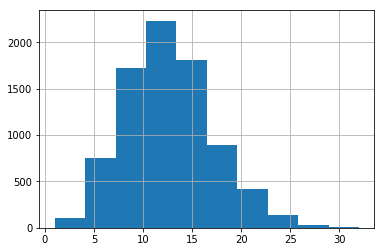

In [74]:
%matplotlib inline

df['foulcommit_home_team'].hist()
#

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000230750FABA8>,
      dtype=object)

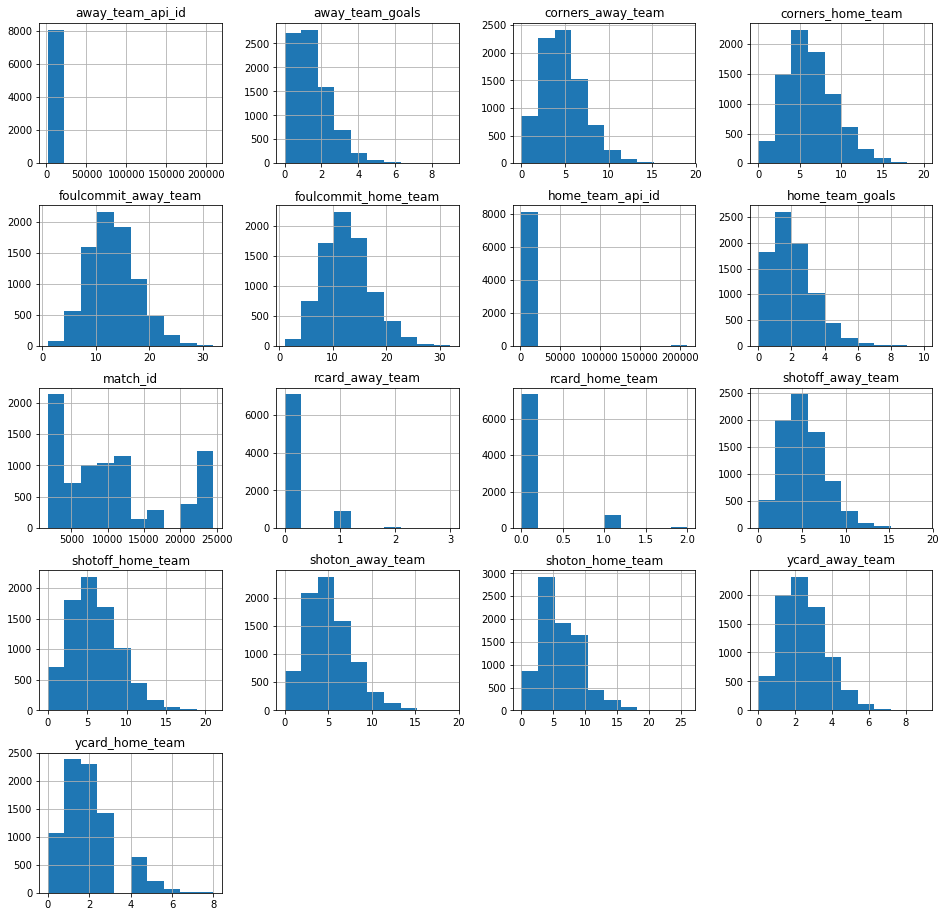

In [77]:
df.hist(figsize=(16,16))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8105 entries, 1728 to 24556
Data columns (total 26 columns):
match_id                8105 non-null int64
league_name             8105 non-null object
country_name            8105 non-null object
home_team_long_name     8105 non-null object
home_team_short_name    8105 non-null object
home_team_api_id        8105 non-null int64
away_team_api_id        8105 non-null int64
away_team_long_name     8105 non-null object
away_team_short_name    8105 non-null object
home_team_goals         8105 non-null int64
away_team_goals         8105 non-null int64
shoton_home_team        8105 non-null float64
shoton_away_team        8105 non-null float64
shotoff_home_team       8105 non-null float64
shotoff_away_team       8105 non-null float64
corners_home_team       8105 non-null float64
corners_away_team       8105 non-null float64
foulcommit_home_team    8105 non-null float64
foulcommit_away_team    8105 non-null float64
possesion_home_team     8105 no

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002301AD930F0>,
      dtype=object)

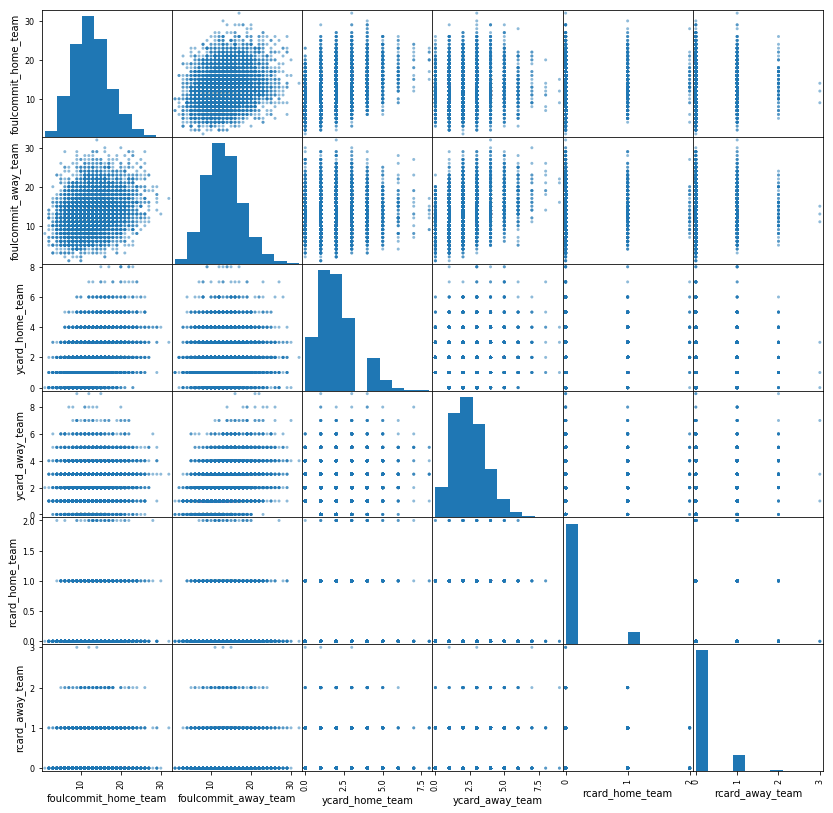

In [104]:
#

df.info()

df_filtered_cols = df.iloc[:, np.arange(17, 25)]
df_filtered_cols.head(10)
pd.plotting.scatter_matrix(df_filtered_cols, figsize=(14,14))

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8105 entries, 1728 to 24556
Data columns (total 26 columns):
match_id                8105 non-null int64
league_name             8105 non-null object
country_name            8105 non-null object
home_team_long_name     8105 non-null object
home_team_short_name    8105 non-null object
home_team_api_id        8105 non-null int64
away_team_api_id        8105 non-null int64
away_team_long_name     8105 non-null object
away_team_short_name    8105 non-null object
home_team_goals         8105 non-null int64
away_team_goals         8105 non-null int64
shoton_home_team        8105 non-null float64
shoton_away_team        8105 non-null float64
shotoff_home_team       8105 non-null float64
shotoff_away_team       8105 non-null float64
corners_home_team       8105 non-null float64
corners_away_team       8105 non-null float64
foulcommit_home_team    8105 non-null float64
foulcommit_away_team    8105 non-null float64
possesion_home_team     8105 no

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002301D37F668>,
      dtype=object)

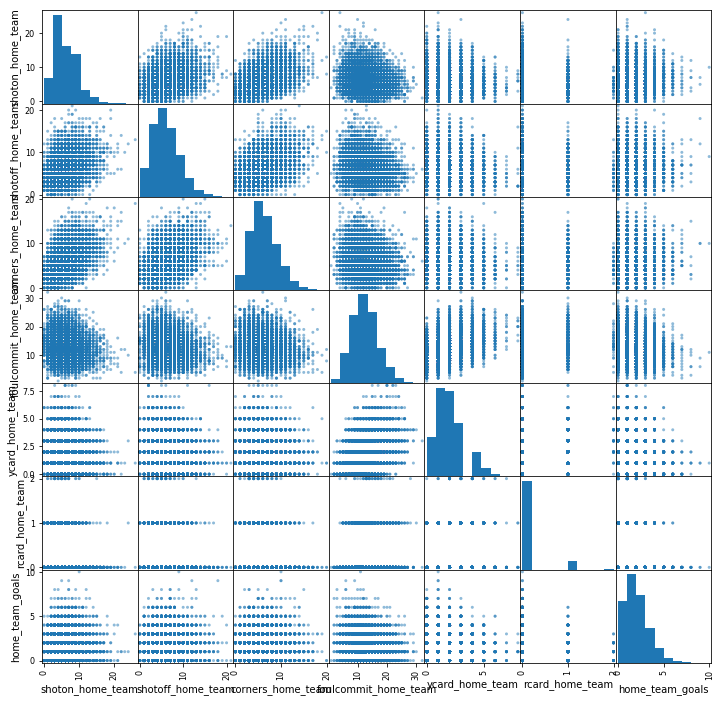

In [111]:
home_team_cols = [col for col in df.columns if '_home_team' in col]
home_team_cols.append('home_team_goals')
pd.plotting.scatter_matrix(df[home_team_cols], figsize=(12,12))

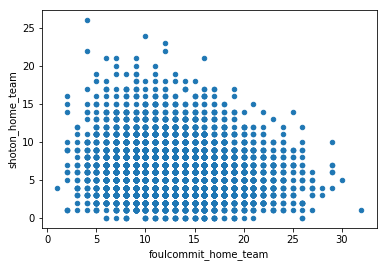

In [112]:
df.plot.scatter(x='foulcommit_home_team', y='shoton_home_team')

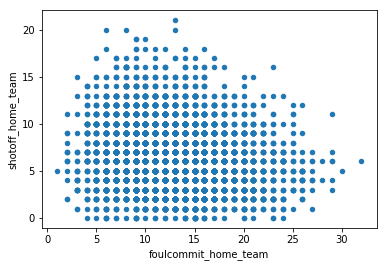

In [113]:
df.plot.scatter(x='foulcommit_home_team', y='shotoff_home_team')